# Installs

In [1]:
!pip install scikit-learn
!pip install pennylane
!pip install torch-geometric

# Model

In [2]:
# with scikit val
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.transforms import BaseTransform
import numpy as np
import pennylane as qml
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

class ScaleFeatures(BaseTransform):
    def __init__(self, target_sum=1.5):
        super().__init__()
        self.target_sum = target_sum  # Desired sum for each feature vector

    def __call__(self, data):
        # Calculate the sum of each node feature vector
        feature_sums = data.x.sum(dim=1, keepdim=True)

        # Calculate the scaling factor to achieve target sum
        scaling_factor = self.target_sum / feature_sums

        # Scale features and update data
        data.x = data.x * scaling_factor

        return data

# Load the dataset and apply normalization
dataset = TUDataset(name="PROTEINS", root='./', transform=ScaleFeatures(target_sum=1.5))

x = [data.x.numpy() for data in dataset]
y = np.array([data.y.item() for data in dataset])

qubits = min(max(len(data) for data in x), 14)

dev = qml.device("lightning.qubit", wires=qubits)

def feature_map(data):
    # Layer 1: Initial rotations
    for i in range(min(len(data), qubits)):
        qml.RY(data[i], wires=i)
        qml.RX(data[i], wires=i)

    # Superposition Layer: After initial rotations
    for i in range(qubits):
        qml.Hadamard(wires=i)

    # Layer 2: Controlled rotations for added non-linearity
    for i in range(1, min(len(data), qubits)):
        qml.CRY(data[i], wires=[i - 1, i])
        qml.CRZ(data[i], wires=[i - 1, i])

    # # Layer 3: Reverse entanglement
    for i in range(qubits - 1, 0, -1):
        for j in range(i - 1, -1, -1):
            qml.CNOT(wires=[i, j])

    # Layer 4: More parameterized rotations
    for i in range(min(len(data), qubits)):
        qml.RX(data[i] * 0.8, wires=i)
        qml.RZ(data[i] * 1.2, wires=i)

    # Layer 5: Ring entanglement
    for i in range(qubits):
        qml.CNOT(wires=[i, (i + 1) % qubits])

    # Layer 6: Final rotations for classification resolution
    for i in range(min(len(data), qubits)):
        qml.RY(data[i], wires=i)
        qml.RZ(data[i], wires=i)

@qml.qnode(dev)
def quantum_circuit(data):
    feature_map(data)
    return [qml.expval(qml.PauliZ(i)) for i in range(qubits)]

def encode_and_transform(data):
    transformed_data = []
    for data_point in data:
        result = quantum_circuit(data_point)
        transformed_data.append(np.array(result))
    return np.array(transformed_data)

def kernel(data1, data2):
    length1 = data1.shape[0]
    length2 = data2.shape[0]

    # Initializes an empty matrix to store all the kernel values
    kernel_matrix = []

    # Compute element-wise fidelity for each pair of samples
    for i in range(length1):
        row = []  # Temp list to store kernel values for the i-th sample
        for j in range(length2):
            fidelity = np.sum(np.abs(data1[i] * data2[j]) ** 2)  # Compute similiarity through a fidelity computation
            row.append(fidelity)  # Append the fidelity value for this pair
        kernel_matrix.append(row)  # Append the row of kernel values

    return np.array(kernel_matrix)

qsvm = SVC(kernel=kernel, C=7)

k = encode_and_transform(x)

scores = cross_val_score(qsvm, k, y, cv=10)

cv_scores = []
for i in scores:
  cv_scores.append(i)
mean_accuracy = np.mean(cv_scores)
std_accuracy = np.std(cv_scores)

print(f"10-Fold Cross-Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}")

10-Fold Cross-Validation Accuracy: 0.7448 ± 0.0375


In [3]:
print(scores)

[0.77678571 0.79464286 0.73214286 0.72072072 0.75675676 0.73873874
 0.72072072 0.68468468 0.71171171 0.81081081]


(<Figure size 11300x1500 with 1 Axes>, <Axes: >)

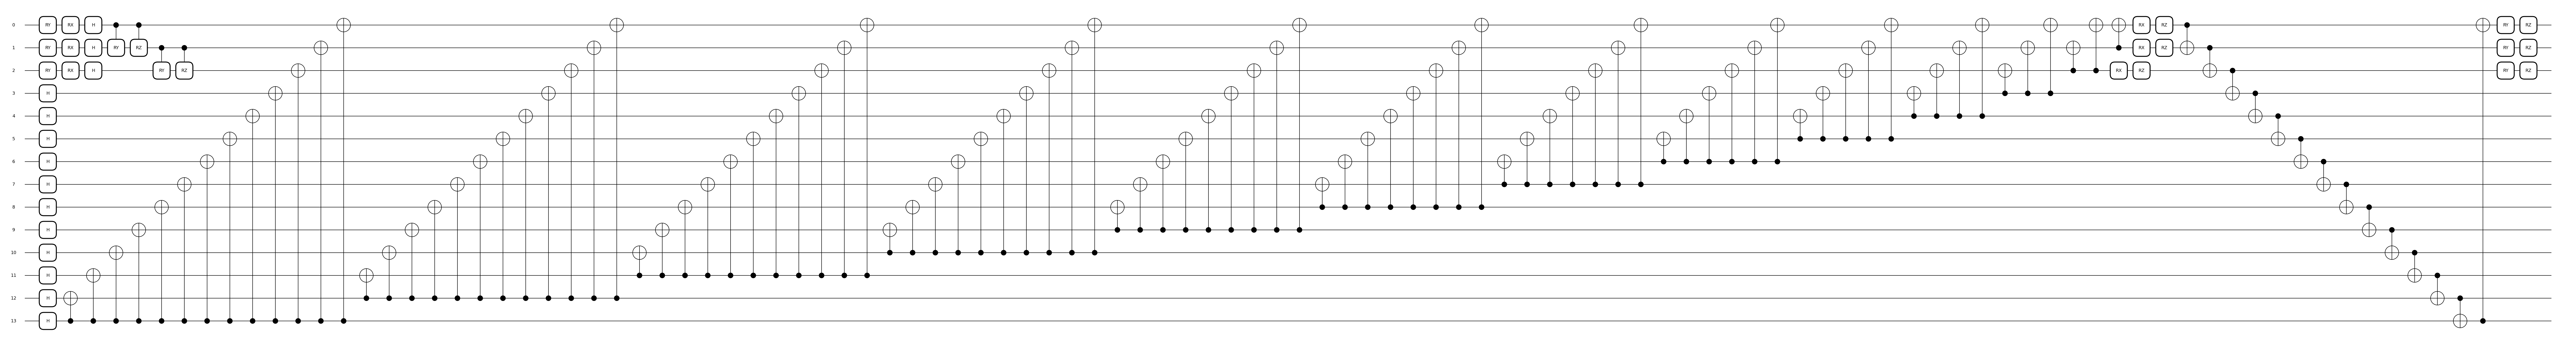

In [4]:
qml.drawer.draw_mpl(feature_map)([1,2,3])